# **Sentiment Analysis for IMDb movies 🍿👀📽**

In this project, I perform sentiment analysis on IMDb movies' reviews. The inputs to my model are **GloVe word embeddings**. I classify the reviews into two classes (Positive and Negative) using **FFNN** (Feed Forward Neural Networks) and I provide a detailed comparison for each method I experimented with. 

---



In [1]:
from google.colab import drive
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

## **Load the dataset** 

For **testing** the model give to **TESTING_DATA_PATH** variable the path where the file with testing data is located

In [2]:
TESTING_DATA_PATH=""
DATA_PATH=""

In [3]:
if not DATA_PATH:
  drive.mount('/content/drive')
  DATA_PATH = "/content/drive/MyDrive/AI_2_exercise_1_data/imdb-reviews.csv"
df = pd.read_csv(filepath_or_buffer=DATA_PATH, sep='\t')

if TESTING_DATA_PATH:
  test_df = pd.read_csv(file_or_buffer=TESTING_DATA_PATH, sep='\t')

Mounted at /content/drive


A look at our data

In [4]:
if not TESTING_DATA_PATH:
  print(f"Dataset shape: {df.shape}")
  pd.set_option('display.max_colwidth', 1000)
  df.head()

Dataset shape: (45008, 3)


Convert the sentiments as following:

* POS → 0
* NEG → 1

In [5]:
 df.loc[df['rating'] < 5, ['rating']] = 0
 df.loc[df['rating'] > 6, ['rating']] = 1
 if TESTING_DATA_PATH:
   test_df.loc[test_df['rating'] < 5, ['rating']] = 0
   test_df.loc[test_df['rating'] > 6, ['rating']] = 1

## **Data pre-processing**

In order to aply logistic regression in the data, they must first be pre-processed.

### **Text Transformation**

In [6]:
if not TESTING_DATA_PATH:
  print(df.isnull().sum())

url       0
rating    0
review    0
dtype: int64


We detect no missing values in the dataset

In [7]:
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer

nltk.download('stopwords')

# Define the function for text transformation
def text_transformation(text):
  # Lower characters
  text = text.lower()
  # Remove links
  text = re.sub('http://\S+|https://\S+', '', text)
  # Remove non letter characters
  text = re.sub(r'[^A-Za-z]+', ' ', text)
  # Remove punctuation
  text = text.translate(str.maketrans('', '', string.punctuation))
  # Remove stopwords
  StopWords = stopwords.words("english")
  text = ' '.join([word for word in text.split() if word not in StopWords])
  # Lemmatization
  snow_stemmer = SnowballStemmer(language='english')
  text = ' '.join([snow_stemmer.stem(word) for word in text.split()])
  
  return text  

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [8]:
df['review'] = df['review'].apply(text_transformation)
if TESTING_DATA_PATH:
  test_df['review'] = test_df['review'].apply(text_transformation)


In [9]:
df.head()

,url,rating,review
0,http://www.imdb.com/title/tt0120623/usercomments,1.0,thought quiet good movi fun watch like best outtak end movi great
1,http://www.imdb.com/title/tt0043117/usercomments,1.0,wagon master uniqu film amongst john ford work main one base stori written john ford stori elabor frank nugent director son patrick ford turn screenplay director person opinion regard wagon master film john ford call one came closest want achiev say say littl ford confess lindsay anderson favourit nonetheless darl clementin br br wagon master ingredi one might expect find john ford film wonder cast deliv best thou featur major star except fordian actor ben johnson peculiar small charact provid obligatori comic relief wagon master quit horn blow sister ledyard jane darwel shot inspir gig last least legendari monument valley john ford fifth passag stagecoach darl clementin fort apach wore yellow ribbon br br film start two friend cowboy travi blue ben johnson sandi owen harri carey jr hire wagon master guid caravan mormon settler head silver valley place like promis land way join peculiar dr locksley hall alan mowbray two beauti women suppos wife daughter call actor head direct simpl...
2,http://www.imdb.com/title/tt0043117/usercomments,1.0,film near perfect film john ford made film magic masterpiec reason ford well ford want know ford great one explain br br photographi cours superb black white black white wonder shot shoulder convers pure ford great moment big littl famous rip pant ward bond appar two dog kept invad set fight ford want use fight scene instead fight one dog ran away attack ward bond rip pant caus ford end mirth whole scene around plait rope way ben johnson burn snuff rope wonder foreshadow anticip final harri carey naiv court prudenc usual ford line scare show bond hors accident fall left film johnson bond fantast scene lord help ford actor stay charact camera roll even hors fall top br br coupl sweet romanc intrud whole focus two likabl lead mention girl number time camera focus ben johnson rather delight backsid br br lot old time stuntmen get line role cliff lyon frank mcgrath wonder charact studi most face stare villain main star set villain rival group western br br mani mani fordian shot face g...
3,http://www.imdb.com/title/tt0835204/usercomments,0.0,gave star lot interest theme mani alreadi mention domest violenc sexual mani taboo therein outsid gore realli would call horror much would scienc fiction br br bleak depress hopeless mind less cheeri end realli tire human suck clich central everi movi know get liber art degre today without bow alter self hatr member human race bout writer director pretend differ everyon els pack notic alien kill human race evil right read believ human deserv die go find lake swim til arm tire way around direct next film write next book tell deserv die aliv silli thought bore
4,http://www.imdb.com/title/tt0499603/usercomments,1.0,movi realli genuin random realli hard find movi like bunch movi hollywood realli enjoy watch movi bought dvd tuesday week watch time love spanglish accent paz realli cute act morgan funni natur br br movi tast might realli differ other say realli love movi simpl best br br learn someth life movi well least usa life life realli random sometim u meet someon pass life friend coincid u spend much time mayb u enjoy u never meet time u togeth realli unforgett keep moment mind grate nice memori br br movi might cheap make price mean total cheap rare learn anyth movi except


### **Text Encoding**

#### **GloVe**

Downloading the glove.6B.zip archive which contains the GloVe word embeddings.


In [10]:
!wget http://nlp.stanford.edu/data/glove.6B.zip

--2022-12-22 07:29:33--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2022-12-22 07:29:33--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-12-22 07:29:33--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [11]:

!unzip glove*.zip

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [12]:
import os
#Builds GloVe dictionary from file name, 
#whose elemenets are of the form word->vector
def GloVe_dictionary(file_name):
  GloVe_dict = {}
  with open(file_name) as f:
      for line in f:
          word, vector = line.split(maxsplit=1)
          vector = np.fromstring(vector, "f", sep=" ")
          GloVe_dict[word] = vector
  return GloVe_dict

In [13]:
#For each text in the dataset check for every word 
#in the text if appears in the GloVe_dict
#If yes, we get the vector from the dictionary for the word, 
#otherwise the vector for the word contains zeros
#In order to get the features vector for each text, we add the vector of each word
#Returns GloVe vectors
def GloVe_Vectors(dataset, GloVe_dict, dimension):
  glove_vectors = []
  for i, text in enumerate(dataset['review']):
    splitted_words = str(text).split(' ')
    words_vectors = np.zeros((len(splitted_words), dimension))
    for j, word in enumerate(splitted_words):
      if word in GloVe_dict:
        words_vectors[j] = GloVe_dict[word]
    text_vector = np.sum(words_vectors, axis=0)
    glove_vectors.append(text_vector)
  return np.array(glove_vectors)

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

We choose GloVe Embeddings with dimension 300 

In [15]:
if not TESTING_DATA_PATH:
  GloVe_dict = GloVe_dictionary('/content/glove.6B.300d.txt')
  GloVe_vectors = GloVe_Vectors(df, GloVe_dict, 300)
  print(f'Train dataset shape: {GloVe_vectors.shape}')
  X_train_GloVe, X_test_GloVe, Y_train, Y_test = train_test_split(GloVe_vectors, df['rating'], test_size=0.2, random_state=42)
  X_train_GloVe, X_val_GloVe, Y_train, Y_val = train_test_split(X_train_GloVe, Y_train, test_size=0.2, random_state=42)

Train dataset shape: (45008, 300)


In [16]:
#Use cuda if present
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device available for running: ")
print(device)

Device available for running: 
cpu


In [17]:
if not TESTING_DATA_PATH:
  X_train_GloVe = torch.tensor(X_train_GloVe)
  X_val_GloVe = torch.tensor(X_val_GloVe)
  X_test_GloVe = torch.tensor(X_test_GloVe)

In [18]:
if not TESTING_DATA_PATH:
  Y_train = torch.squeeze(torch.from_numpy(Y_train.to_numpy()).float())
  Y_val = torch.squeeze(torch.from_numpy(Y_val.to_numpy()).float())
  Y_test = torch.squeeze(torch.from_numpy(Y_test.to_numpy()).float())

## **Feed-Forward Neural Network** 

The model conists of one input layer, one hidden layer having the ReLu activation function and one output layer having the sigmoid function.
The *structure* of the network is as follows:

Input $\rightarrow$  
  Linear Layer $\rightarrow$ ReLU  
  Linear Layer $\rightarrow$ Sigmoid  
$\rightarrow$ Output

In [19]:
class Net(nn.Module):
    def __init__(self, D_in, H1, D_out):
        super(Net, self).__init__()
        
        self.linear1 = nn.Linear(D_in, H1)
        self.relu_1 = nn.ReLU()

        self.linear2 = nn.Linear(H1, H1)
        self.relu_2 = nn.ReLU()

        self.linear3 = nn.Linear(H1, D_out)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        out = self.linear1(x)
        out = self.relu_1(out)

        out = self.linear2(out)
        out = self.relu_2(out)

        out = self.linear3(out)
        out = self.sigmoid(out)

        return out

### Experimenting

In [20]:
def plot_acc_per_features(features_list, acc_list, title):
  fig = plt.figure(figsize=(6, 4))

  plt.plot(features_list, acc_list)
  plt.title(title)
  plt.xlabel("No of Features")
  plt.ylabel("Accuracy")
  plt.tight_layout()
  plt.show()

In [21]:
def get_accuracy(y_true, y_pred):
  y_pred = torch.round(y_pred)
  correct = (y_true == y_pred).float() 
  accuracy = correct.sum() / len(correct)
  return accuracy

In [22]:
def train_ffnn(model, n_epochs, trainX_batches, trainY_batches, loss_func, optimizer):
  for epoch in range(n_epochs):
    for x_batch, y_batch in zip(trainX_batches, trainY_batches):
      x_batch = x_batch.to(device)
      y_batch = y_batch.to(device)
      y_pred = model.forward(x_batch.float())
      y_pred = torch.squeeze(y_pred)
      
      train_loss = loss_func(y_pred, y_batch)
      optimizer.zero_grad()
      train_loss.backward()
      optimizer.step()

In [23]:
def train_val_loss_acc(model, n_epochs, trainX_batches, trainY_batches, loss_func, optimizer, X_val_GloVe, Y_val, print_res = False):
  train_losses, train_accuracies, val_losses, val_accuracies = [], [], [], []
  for epoch in range(n_epochs):
    epoch_loss = epoch_accuracy = 0
    val_loss = val_accuracy = 0
    for x_batch, y_batch in zip(trainX_batches, trainY_batches):
      x_batch = x_batch.to(device)
      y_batch = y_batch.to(device)
      y_pred = model.forward(x_batch.float())
      y_pred = torch.squeeze(y_pred)
      
      train_loss = loss_func(y_pred, y_batch)
      epoch_loss += train_loss.item()
      optimizer.zero_grad()
      train_loss.backward()
      optimizer.step()
      
      epoch_accuracy += get_accuracy(y_batch, y_pred)


    X_val_GloVe=X_val_GloVe.to(device)
    Y_val=Y_val.to(device)

    val_prediction = model.forward(X_val_GloVe.float())
    val_prediction = torch.squeeze(val_prediction)
    val_loss = loss_func(val_prediction, Y_val)
    validation_loss = val_loss.item()
    val_accuracy = get_accuracy(Y_val, val_prediction)

    epoch_loss /= len(trainX_batches)
    epoch_accuracy /= len(trainX_batches)
    val_losses.append(validation_loss)
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy.cpu())
    val_accuracies.append(val_accuracy.cpu())
    if(print_res):
      print("Epoch:", epoch, "\n"
            "Train Loss:     \t", round(epoch_loss, 4),      "\tTrain Accuracy:      \t", round(epoch_accuracy.item(), 4), "\n"
            "Validation Loss:\t", round(validation_loss, 4), "\tValidation Accuracy: \t", round(val_accuracy.item(), 4),   "\n")
  return train_losses, val_losses, train_accuracies, val_accuracies
        

In [24]:
def plot_loss_acc(train_losses, val_losses, train_accuracies, val_accuracies, n_epochs, append_to_tile=""):
  plt.style.use("ggplot")
  plt.figure(figsize=(6, 4))

  plt.plot(np.arange(0, n_epochs), train_losses, label="train_loss")
  plt.plot(np.arange(0, n_epochs), val_losses, label="val_loss")
  plt.plot(np.arange(0, n_epochs), train_accuracies, label="train_acc")
  plt.plot(np.arange(0, n_epochs), val_accuracies, label="val_acc")
  plt.title("Training Loss and Accuracy" + append_to_tile)
  plt.xlabel("Epoch")
  plt.ylabel("Loss/Accuracy")
  plt.legend()

In [25]:
if not TESTING_DATA_PATH:
  D_in = X_train_GloVe.shape[1]
  H1 = 150
  D_out = 1
  n_epochs = 100

In [26]:
if not TESTING_DATA_PATH:
  learning_rates=[0.01, 0.001, 0.0001, 0.00001]
  weight_decays = [0.01, 0.001, 0.0001]

In [27]:
if not TESTING_DATA_PATH:
  lr_wd = []
  for lr in learning_rates:
    for wd in weight_decays:
      lr_wd.append((lr,wd))
  print(lr_wd)

[(0.01, 0.01), (0.01, 0.001), (0.01, 0.0001), (0.001, 0.01), (0.001, 0.001), (0.001, 0.0001), (0.0001, 0.01), (0.0001, 0.001), (0.0001, 0.0001), (1e-05, 0.01), (1e-05, 0.001), (1e-05, 0.0001)]


Grid search for parameters learning rate and weight decay

Epoch: 0 
Train Loss:     	 0.8094 	Train Accuracy:      	 0.7102 
Validation Loss:	 0.4946 	Validation Accuracy: 	 0.7841 

Epoch: 1 
Train Loss:     	 0.4884 	Train Accuracy:      	 0.7819 
Validation Loss:	 0.4551 	Validation Accuracy: 	 0.8037 

Epoch: 2 
Train Loss:     	 0.4828 	Train Accuracy:      	 0.7833 
Validation Loss:	 0.4597 	Validation Accuracy: 	 0.803 

Epoch: 3 
Train Loss:     	 0.4791 	Train Accuracy:      	 0.786 
Validation Loss:	 0.4615 	Validation Accuracy: 	 0.8037 

Epoch: 4 
Train Loss:     	 0.481 	Train Accuracy:      	 0.7872 
Validation Loss:	 0.4734 	Validation Accuracy: 	 0.7905 

Epoch: 5 
Train Loss:     	 0.4757 	Train Accuracy:      	 0.7847 
Validation Loss:	 0.4537 	Validation Accuracy: 	 0.8031 

Epoch: 6 
Train Loss:     	 0.4678 	Train Accuracy:      	 0.7893 
Validation Loss:	 0.45 	Validation Accuracy: 	 0.8069 

Epoch: 7 
Train Loss:     	 0.4665 	Train Accuracy:      	 0.787 
Validation Loss:	 0.4819 	Validation Accuracy: 	 0.7806 

Epoch:

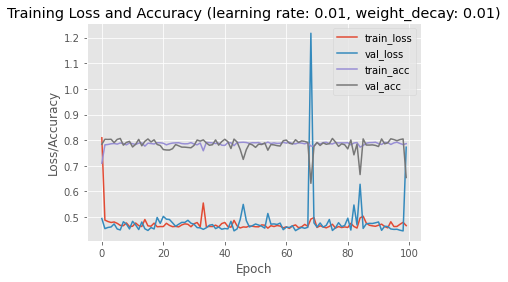

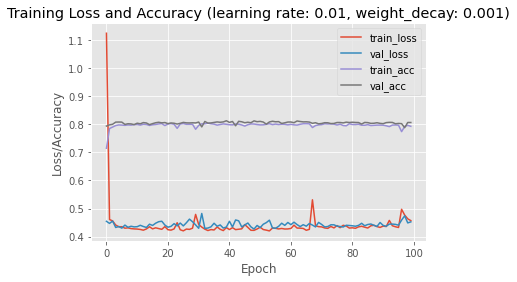

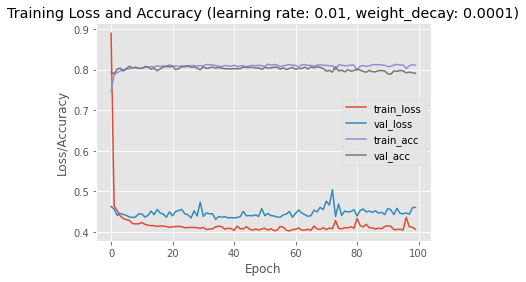

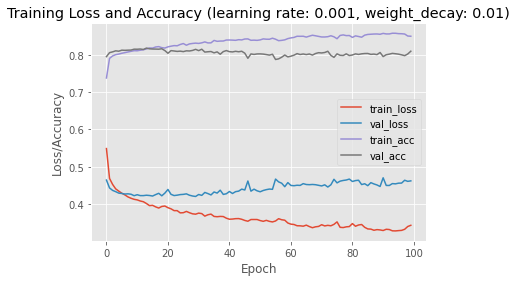

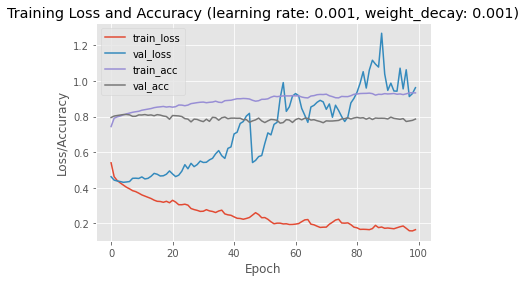

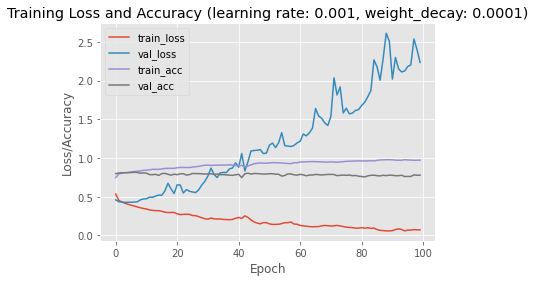

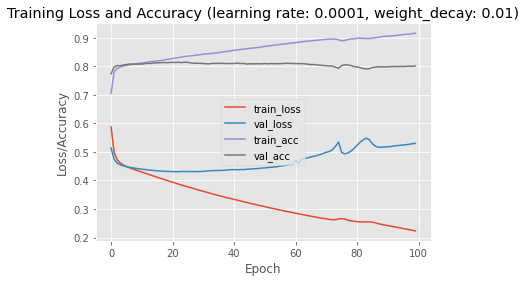

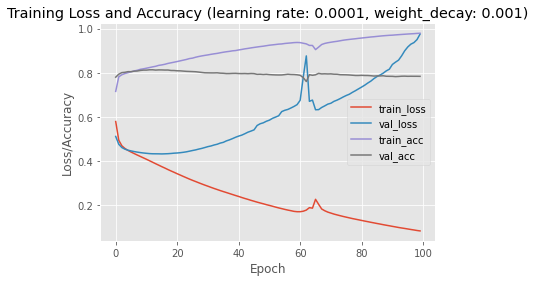

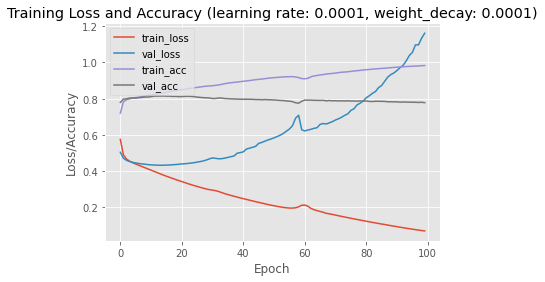

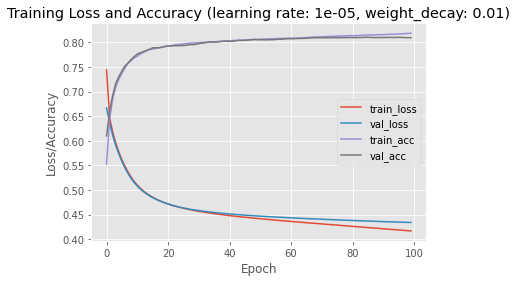

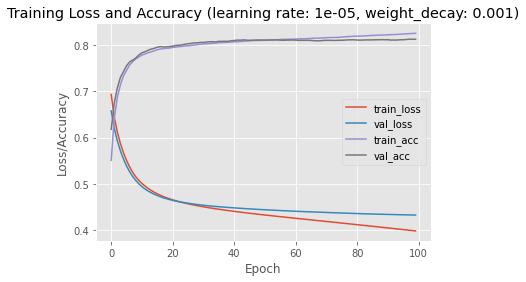

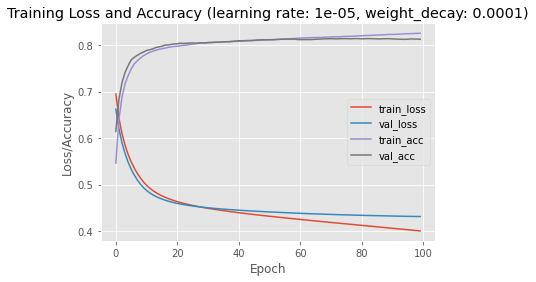

In [28]:
if not TESTING_DATA_PATH:
  batch_size = 256
  n_epochs=100

  for lr,wd in lr_wd:
    model = Net(D_in, H1, D_out)
    model.to(device)
    loss_func = nn.BCELoss()
    loss_func.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
    trainX_batches = torch.split(X_train_GloVe, batch_size)
    trainY_batches = torch.split(Y_train, batch_size)

    train_losses, val_losses, train_accuracies, val_accuracies = train_val_loss_acc(model, n_epochs, trainX_batches, trainY_batches, loss_func, optimizer, X_val_GloVe, Y_val, print_res = True)
    plot_loss_acc(train_losses, val_losses, train_accuracies, val_accuracies, n_epochs, append_to_tile = " (learning rate: " + str(lr) + ", weight_decay: " + str(wd) + ")")

Experimenting with the number of features

In [29]:
if not TESTING_DATA_PATH:
  file_names = ['/content/glove.6B.50d.txt', '/content/glove.6B.100d.txt', '/content/glove.6B.200d.txt', '/content/glove.6B.300d.txt']
  GloVe_prec_list = []
  GloVe_recall_list = []
  GloVe_f1_list = []
  dims_list = [50,100,200,300]
  accs = []
  batch_size = 256
  n_epochs = 100
  lr=0.00001
  wd = 0.01
  H1 = 150
  D_out = 1
  for file_name, dims in zip(file_names, dims_list):
    GloVe_dict = GloVe_dictionary(file_name)
    GloVe_vectors = GloVe_Vectors(df, GloVe_dict, dims)
    X_train_GloVe, X_test_GloVe, Y_train, Y_test = train_test_split(GloVe_vectors, df['rating'], test_size=0.2, random_state=42)
    X_train_GloVe = torch.tensor(X_train_GloVe)
    X_test_GloVe = torch.tensor(X_test_GloVe)
    Y_train = torch.squeeze(torch.from_numpy(Y_train.to_numpy()).float())
    Y_test = torch.squeeze(torch.from_numpy(Y_test.to_numpy()).float())

    D_in = X_train_GloVe.shape[1]
    model = Net(D_in, H1, D_out)
    model.to(device)

    loss_func = nn.BCELoss()
    loss_func.to(device)

    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=wd)

    trainX_batches = torch.split(X_train_GloVe, batch_size)
    trainY_batches = torch.split(Y_train, batch_size)
    train_ffnn(model, n_epochs, trainX_batches, trainY_batches, loss_func, optimizer)

    X_test_GloVe = X_test_GloVe.to(device)
    Y_test = Y_test.to(device)

    test_prediction = model.forward(X_test_GloVe.float())
    test_prediction = torch.squeeze(test_prediction)

    test_accuracy = get_accuracy(Y_test, test_prediction)
    accs.append(round(test_accuracy.item(), 2))
    print('Model accuracy on test dataset:', round(test_accuracy.item(), 2), "\n")

Model accuracy on test dataset: 0.73 

Model accuracy on test dataset: 0.77 

Model accuracy on test dataset: 0.8 

Model accuracy on test dataset: 0.81 



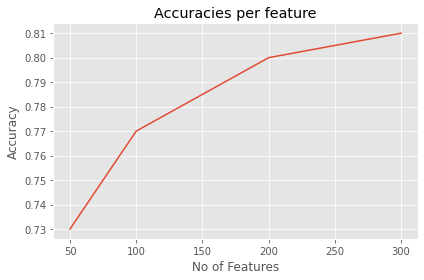

In [30]:
if not TESTING_DATA_PATH:
  plot_acc_per_features(features_list=dims_list, acc_list = accs, title="Accuracies per feature")

### **Final Model**

In [31]:
GloVe_dict = GloVe_dictionary('/content/glove.6B.300d.txt')
GloVe_vectors = GloVe_Vectors(df, GloVe_dict, 300)
print(f'Train dataset shape: {GloVe_vectors.shape}')
X_train_GloVe, X_test_GloVe, Y_train, Y_test = train_test_split(GloVe_vectors, df['rating'], test_size=0.2, random_state=42)
if not TESTING_DATA_PATH:
    X_train_GloVe, X_val_GloVe, Y_train, Y_val = train_test_split(X_train_GloVe, Y_train, test_size=0.2, random_state=42)

Train dataset shape: (45008, 300)


In [32]:
if TESTING_DATA_PATH:
  X_test_GloVe = GloVe_Vectors(test_df, GloVe_dict, 300)
  Y_test = test_df['rating']

In [33]:
X_train_GloVe = torch.tensor(X_train_GloVe)
X_test_GloVe = torch.tensor(X_test_GloVe)
Y_train = torch.squeeze(torch.from_numpy(Y_train.to_numpy()).float())
Y_test = torch.squeeze(torch.from_numpy(Y_test.to_numpy()).float())

In [34]:
if not TESTING_DATA_PATH:
  X_val_GloVe = torch.tensor(X_val_GloVe)
  Y_val = torch.squeeze(torch.from_numpy(Y_val.to_numpy()).float())

In [35]:
D_in = X_train_GloVe.shape[1]
H1 = 150
D_out = 1
n_epochs = 100

Epoch: 0 
Train Loss:     	 0.8452 	Train Accuracy:      	 0.4984 
Validation Loss:	 0.6985 	Validation Accuracy: 	 0.5193 

Epoch: 1 
Train Loss:     	 0.685 	Train Accuracy:      	 0.5607 
Validation Loss:	 0.6605 	Validation Accuracy: 	 0.6133 

Epoch: 2 
Train Loss:     	 0.6515 	Train Accuracy:      	 0.635 
Validation Loss:	 0.6308 	Validation Accuracy: 	 0.6684 

Epoch: 3 
Train Loss:     	 0.6239 	Train Accuracy:      	 0.6784 
Validation Loss:	 0.606 	Validation Accuracy: 	 0.6987 

Epoch: 4 
Train Loss:     	 0.6012 	Train Accuracy:      	 0.707 
Validation Loss:	 0.5851 	Validation Accuracy: 	 0.7216 

Epoch: 5 
Train Loss:     	 0.5818 	Train Accuracy:      	 0.7265 
Validation Loss:	 0.5672 	Validation Accuracy: 	 0.7379 

Epoch: 6 
Train Loss:     	 0.565 	Train Accuracy:      	 0.7414 
Validation Loss:	 0.5515 	Validation Accuracy: 	 0.7484 

Epoch: 7 
Train Loss:     	 0.5507 	Train Accuracy:      	 0.7505 
Validation Loss:	 0.5382 	Validation Accuracy: 	 0.7583 

Epoch

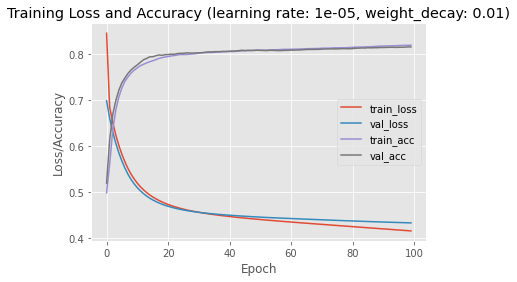

In [36]:
if not TESTING_DATA_PATH:
  batch_size = 256
  n_epochs = 100
  lr=0.00001
  wd = 0.01
  model = Net(D_in, H1, D_out)
  model.to(device)

  loss_func = nn.BCELoss()
  loss_func.to(device)

  optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=wd)

  trainX_batches = torch.split(X_train_GloVe, batch_size)
  trainY_batches = torch.split(Y_train, batch_size)
  train_losses, val_losses, train_accuracies, val_accuracies = train_val_loss_acc(model, n_epochs, trainX_batches, trainY_batches, loss_func, optimizer, X_val_GloVe, Y_val, print_res = True)

  plot_loss_acc(train_losses, val_losses, train_accuracies, val_accuracies, n_epochs, append_to_tile = " (learning rate: " + str(lr) + ", weight_decay: " + str(wd) + ")")

### **Training**

In [37]:
batch_size = 256
n_epochs = 100
lr=0.00001
wd = 0.01
model = Net(D_in, H1, D_out)
model.to(device)

loss_func = nn.BCELoss()
loss_func.to(device)

optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=wd)

trainX_batches = torch.split(X_train_GloVe, batch_size)
trainY_batches = torch.split(Y_train, batch_size)
train_ffnn(model, n_epochs, trainX_batches, trainY_batches, loss_func, optimizer)

### **Testing**

In [38]:
X_test_GloVe = X_test_GloVe.to(device)
Y_test = Y_test.to(device)

test_prediction = model.forward(X_test_GloVe.float())
test_prediction = torch.squeeze(test_prediction)

test_accuracy = get_accuracy(Y_test, test_prediction)
print('Model accuracy on test dataset:', round(test_accuracy.item(), 2), "\n")

Model accuracy on test dataset: 0.81 



In [39]:
from sklearn.metrics import classification_report

test_prediction = test_prediction.to(device)
test_prediction = test_prediction.ge(.5).view(-1).cpu()
testY = Y_test.cpu()

print(classification_report(testY, test_prediction))

              precision    recall  f1-score   support

         0.0       0.82      0.80      0.81      4550
         1.0       0.80      0.83      0.81      4452

    accuracy                           0.81      9002
   macro avg       0.81      0.81      0.81      9002
weighted avg       0.81      0.81      0.81      9002



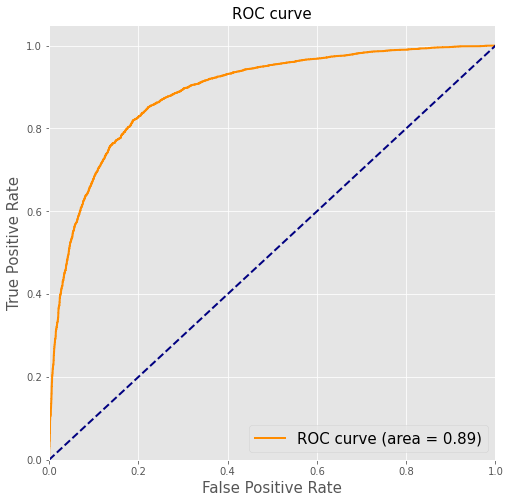

In [40]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc, classification_report

y_score = model.forward(X_test_GloVe.float())

y_score = y_score.cpu().detach().numpy()
y = testY.cpu().detach().numpy()

y_test = label_binarize(y, classes=[0, 1])
n_classes = y_test.shape[1]

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:,i], y_score[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(8,8))
lw = 2
plt.plot(fpr[0], tpr[0], color='darkorange',lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[0])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate',fontsize=15)
plt.ylabel('True Positive Rate',fontsize=15)
plt.title('ROC curve', fontsize=15)
plt.legend(loc="lower right",fontsize=15)
plt.show()